check each column values is same

In [1]:
import pandas as pd
import numpy as np

test = pd.read_csv("./test.gz")

train = pd.read_csv("train.gz", chunksize=5000000)
sample = pd.DataFrame()
for s in train:
    sample = pd.concat([sample, s])

In [2]:
sample.isna().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [3]:
sample.click.value_counts()

0    33563901
1     6865066
Name: click, dtype: int64

In [4]:
diff_value_list = []
for column in sample.columns[3:]:
    diff = list(set(test[column].to_list()).difference(set(sample[column].to_list())))
    if len(test[test[column].isin(diff)]) > len(test)*0.01:
        diff_value_list.append(column)

In [5]:
diff_value_list

['site_id', 'device_id', 'device_ip', 'C14', 'C17', 'C21']

dim > 10 transfer to dim == 5

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
test = pd.read_csv("./test.gz")

train = pd.read_csv("train.gz", chunksize=5000000)
sample = pd.DataFrame()
for s in train:
    sample = pd.concat([sample, s])

In [3]:
diff_value_list = ['site_id', 'device_id', 'device_ip', 'C14', 'C17', 'C21']

In [4]:
sample.drop('id', axis=1, inplace=True)
sample.drop(diff_value_list, axis=1, inplace=True)
test.drop(diff_value_list, axis=1, inplace=True)

In [5]:
sample['hour'] = sample['hour'].apply(lambda x: int(int(str(x)[-2:])/2))
test['hour'] = test['hour'].apply(lambda x: int(int(str(x)[-2:])/2))

In [6]:
transfer_list = []
for column in sample.columns[2:]:
    length = len(set(sample[column].to_list()))
    if length >= 10:
        transfer_list.append(column)
    print(column, ' : ', length)

C1  :  7
banner_pos  :  7
site_domain  :  7745
site_category  :  26
app_id  :  8552
app_domain  :  559
app_category  :  36
device_model  :  8251
device_type  :  5
device_conn_type  :  4
C15  :  8
C16  :  9
C18  :  4
C19  :  68
C20  :  172


In [7]:
mean = sample['click'].describe()['mean']

In [8]:
def transfer(df, col, mean, df_t):
    d = df.groupby([col])['click'].agg('mean').to_dict()
    for key in d.keys():
        if d[key] < mean-0.09:
            d[key] = 1
        elif mean-0.09 <= d[key] < mean-0.07:
            d[key] = 2
        elif mean-0.07 <= d[key] < mean-0.05:
            d[key] = 3
        elif mean-0.05 <= d[key] < mean-0.03:
            d[key] = 4
        elif mean-0.03 <= d[key] < mean-0.01:
            d[key] = 5
        elif mean-0.01 <= d[key] < mean+0.01:
            d[key] = 6
        elif mean+0.01 <= d[key] < mean+0.03:
            d[key] = 7
        elif mean+0.03 <= d[key] < mean+0.05:
            d[key] = 8
        elif mean+0.05 <= d[key] < mean+0.07:
            d[key] = 9
        elif mean+0.07 <= d[key] < mean+0.09:
            d[key] = 10
        else:
            d[key] = 11
    df[col] = df[col].apply(lambda x: d[x])
    df_t[col] = df_t[col].apply(lambda x: d[x] if x in d.keys() else 6)
    return df, df_t

In [9]:
for col in transfer_list:
    sample, test = transfer(sample, col, mean, test)

In [10]:
def standardization(df, col, df_t):
    a_dictionary = df.groupby([col])['click'].agg('count').to_dict()
    max_key = max(a_dictionary, key=a_dictionary.get)
    d = {}
    num = 1
    for v in set(df[col]):
        d[v] = num
        num+=1
    df[col] = df[col].apply(lambda x: d[x])
    df_t[col] = df_t[col].apply(lambda x: d[x] if x in d.keys() else 0)
    return df, df_t

In [11]:
standard_list = set(sample.columns[1:].to_list()).difference(set(transfer_list))

In [12]:
for col in standard_list:
    sample, test = standardization(sample, col, test)

In [13]:
sample.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

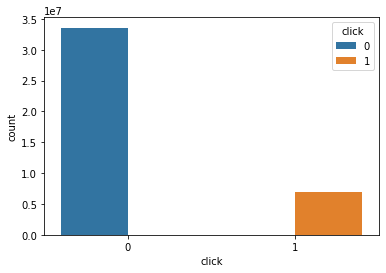

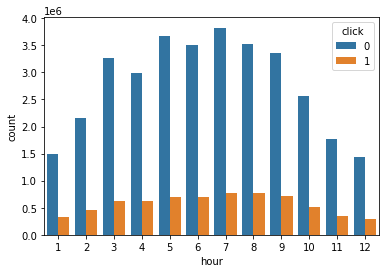

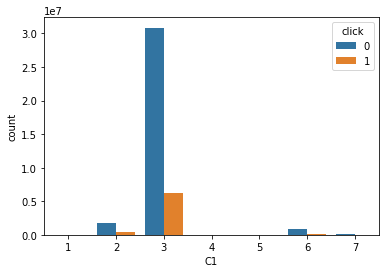

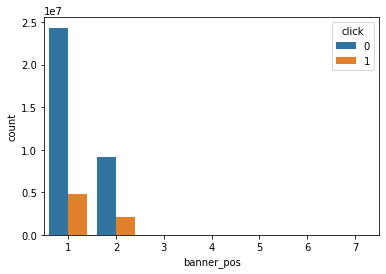

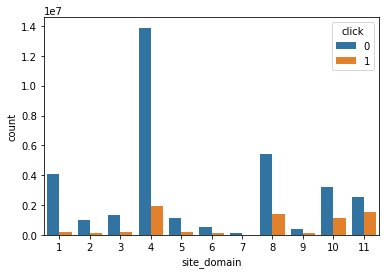

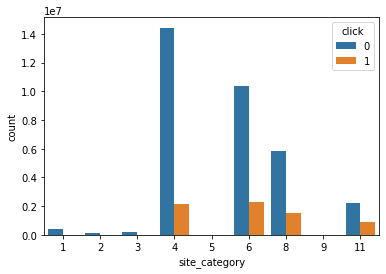

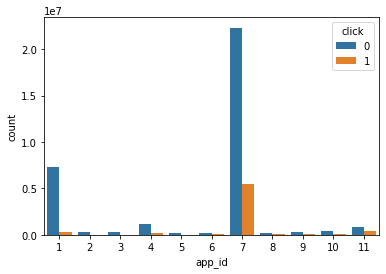

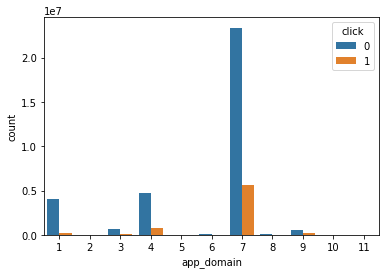

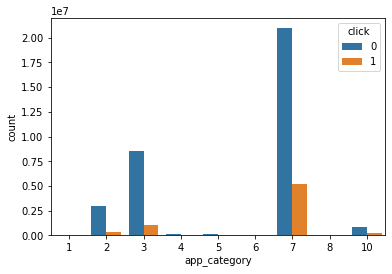

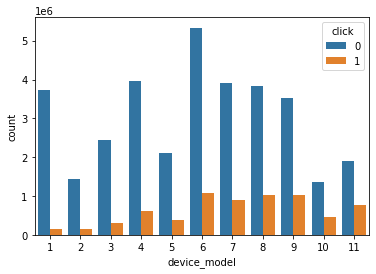

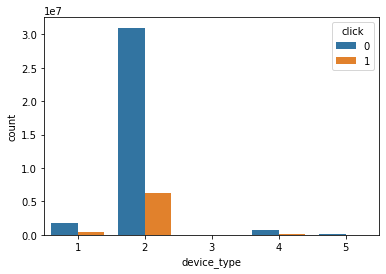

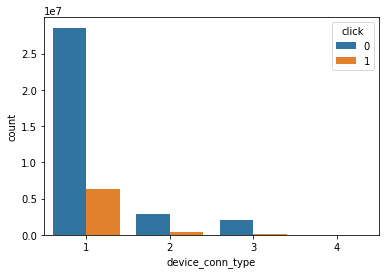

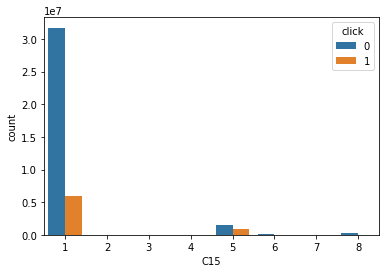

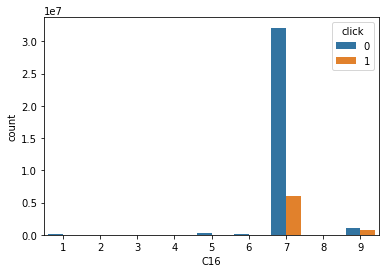

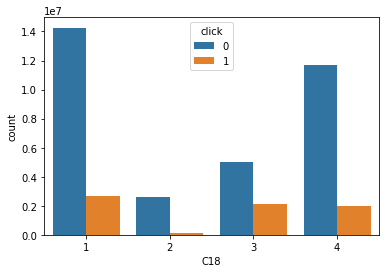

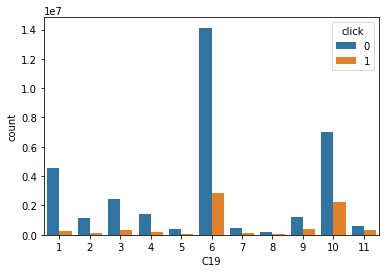

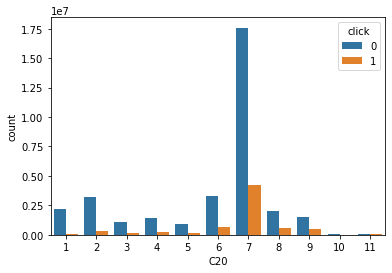

In [13]:
for col in sample.columns:
    sns.countplot(x = col, hue = "click", data = sample)
    plt.show()

In [2]:
sample = pd.read_csv('train.csv')

In [14]:
sample = sample.sample(frac=1).reset_index(drop=True)
sample[:int(len(sample)*0.2)].to_csv('./data/validation.csv', index=False)
sample[int(len(sample)*0.2):].to_csv('./data/train.csv', index=False)

In [1]:
import pandas as pd
import numpy as np

In [2]:
transfer_list = ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'C14', 'C17', 'C19', 'C20', 'C21']

In [3]:
all_data = pd.concat([pd.read_csv("train.csv"), pd.read_csv("validation.csv"), pd.read_csv("test.csv")], ignore_index=True)

In [4]:
columns = all_data.columns[1:-1]
for col in columns:
    if col in transfer_list:
        continue
    all_data = pd.concat([all_data.drop(col, axis=1), pd.get_dummies(all_data[col])], axis=1)

In [5]:
all_data[all_data['id'].notnull()].drop('click', axis=1).to_csv('./data/test_hot.csv', index=False)

In [6]:
all_data = all_data[all_data['click'].notnull()].drop('id', axis=1)
all_data = all_data.sample(frac=1).reset_index(drop=True)
all_data[:int(len(all_data)*0.2)].to_csv('./data/validation_hot.csv', index=False)
all_data[int(len(all_data)*0.2):].to_csv('./data/train_hot.csv', index=False)

In [7]:
train = pd.read_csv("./data/train_hot.csv", chunksize=10000000)
for i, df in enumerate(train):
    df.to_csv(f'./data/train_hot_{i}.csv', index=False)